In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Controllo PID di un sistema del secondo ordine sovrasmorzato

Nell'esempio seguente, utilizzeremo un controller PID (o uno dei suoi sottotipi) per controllare un sistema LTI (linear time-invariant) del secondo ordine sovrasmorzato.

I due poli del sistema sono distinti e reali e di conseguenza ci sono due intorni in cui il modulo della funzione di trasferimento cambia pendenza. I due poli possono essere definiti semplicemente dai loro valori reali.
<br>
$$G(s)=\frac{1}{s^2+(P_1+P_2)s+P_1P_2}$$
<br>
Vari esempi in forma di circuiti analogici:
<br><br>
<table><tbody><tr>
<td><center><img src="Images/second_order_separate.png" width="75%" /></center></td>
<td><center><img src="Images/second_order_adjustable.png" width="70%" /></center></td>
</tr>
<tr>
<td><center>Filtri RC in cascata</center></td><td><center>circuito RLC $\left(\frac{R}{2}\sqrt{\frac{C}{L}}>1\right)$</center></td>
</tr></tbody></table>
<br>
Funzione di trasferimento dell'implementazione RLC:
<br>
<br>
$$G(s) = \frac{V_{out}(s)}{V_{in}(s)} = K\frac{1}{s^2+2\zeta\omega_0 s+\omega_0^2}=\frac{1}{LC}\frac{1}{s^2+\frac{R}{L}+\frac{1}{LC}} \qquad \omega_0=\frac{1}{LC} \qquad \zeta=\frac{R}{2}\sqrt{\frac{C}{L}}>1$$
<br>

<b>Scegli i poli del sistema!</b>

<IPython.core.display.Javascript object>


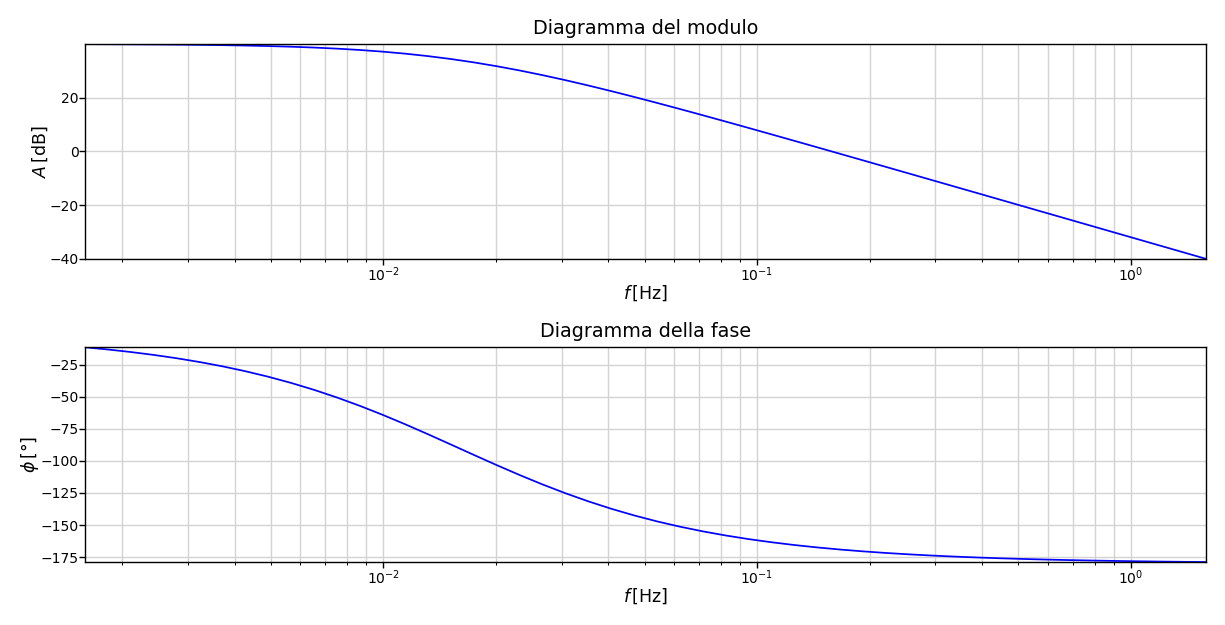

Output()

In [2]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Diagramma del modulo', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Diagramma della fase', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)   


# System model

def system_model(pole1, pole2):

    W_sys = c.tf([1], [1, pole1+pole2, pole1*pole2])

    print('Funzione di trasferimento:')
    print(W_sys)

    # System analysis

    poles = c.pole(W_sys)     # Poles

    print('Poli del sistema:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)

    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot

    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets
    
p1_slider = w.FloatLogSlider(value=0.1, base=10, min=-4, max=1, description='P1.Re (negativo) :', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'50%'})
p2_slider = w.FloatLogSlider(value=0.1, base=10, min=-4, max=1, description='P2.Re (negativo) :', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'50%'})

input_data = w.interactive_output(system_model, {'pole1':p1_slider, 'pole2':p2_slider})

display(w.HBox([p1_slider, p2_slider]), input_data)

Dopo aver osservato le caratteristiche del sistema, <b>seleziona un tipo di controllore!</b>

In [3]:
#Controller type select

typeSelect = w.ToggleButtons(
    options=[('P', 0), ('PI', 1), ('PD', 2), ('PID', 3), ('PID Reale', 4)],
    description='Controller: ', style={'description_width':'15%'})

display(typeSelect)

ToggleButtons(description='Controller: ', options=(('P', 0), ('PI', 1), ('PD', 2), ('PID', 3), ('PID Reale', 4…

<b>Modifica i valori del controller in modo che il tempo di salita/assestamento, l'overshoot o l'errore rimanente siano minimi!</b><br>
Non è possibile ottenere i migliori risultati per ogni parametro in una singola configurazione. Crea più soluzioni, una per ogni tipo!

<IPython.core.display.Javascript object>


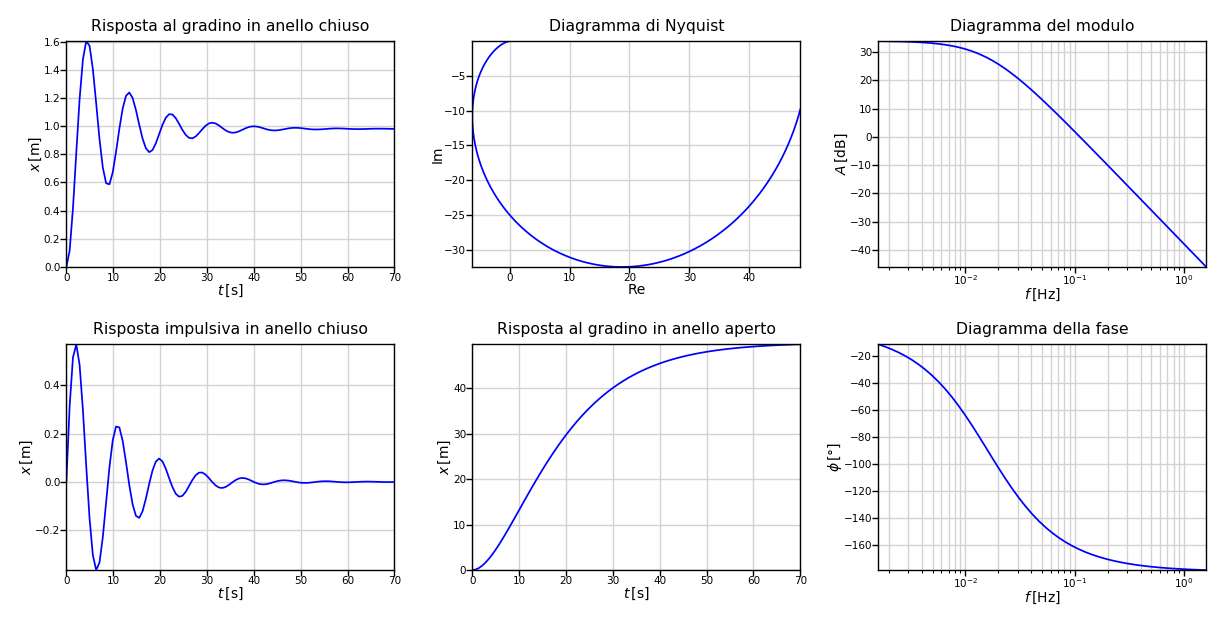

Output()

In [4]:
# PID control

# Figure definition
fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)

f2_ax1.set_title('Risposta al gradino in anello chiuso', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Diagramma di Nyquist', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Diagramma del modulo', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Risposta impulsiva in anello chiuso', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Risposta al gradino in anello aperto', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Diagramma della fase', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def pid_control(Kp, Ti, Td, Fd, type_select, pole1, pole2):
    
    W_sys = c.tf([1], [1, pole1+pole2, pole1*pole2])
    
    if type_select in (1, 3, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select == 4:
        Fd0 = 1
    else:
        Fd0 = 0
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys)         # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
                        
    # Display
                        
    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue') 

    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')

    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')   
    
    tout, yout = c.step_response(W_open)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue') 
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
# GUI widgets

def draw_controllers(type_select):
    
    global Kp_slider
    global Ti_slider
    global Td_slider
    global Fd_slider
    
    Kp_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='Kp:', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'))
    
    if type_select in (1, 3, 4):
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        
    if type_select in (2, 3, 4):
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
    
    if type_select == 4:
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)


    input_data = w.interactive_output(pid_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                      'Fd': Fd_slider, 'type_select':typeSelect, 'pole1':p1_slider, 'pole2':p2_slider})

    display(w.HBox([Kp_slider, Ti_slider, Td_slider, Fd_slider]), input_data)
    
w.interactive_output(draw_controllers, {'type_select':typeSelect})

È possibile testare le funzionalità di inseguimento del riferimento del sistema controllato utilizzando la simulazione.<br>
<b>Modifica il controller in modo che sia capace di seguire una sinusoide in modo accettabile!</b>
<br><br>
<i>(Le animazioni vengono ridimensionate per adattarsi alla figura durante l'intera simulazione. A causa di questo, le soluzioni instabili potrebbero sembrare non muoversi prima dell'ultimo istante.)</i>

<IPython.core.display.Javascript object>


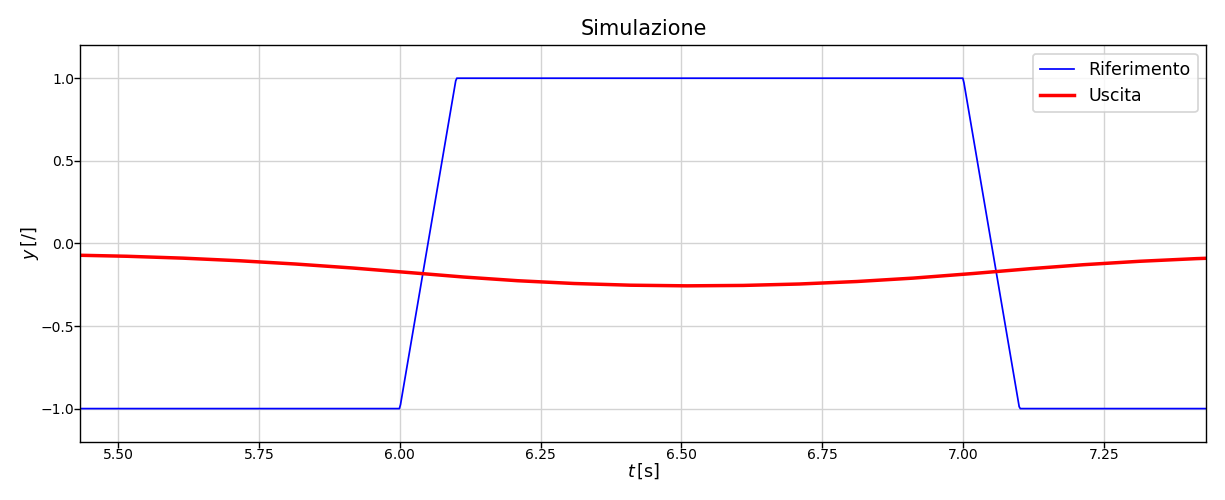

Output()

In [5]:
# Simulation data

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 4))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(111)

frame_count=1000
scope_rounds=4

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')

line1 = l1[0]
line2 = l2[0]

anim_ax1.legend(l1+l2, ['Riferimento', 'Uscita'], loc=1)

anim_ax1.set_title('Simulazione', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$y\/$[/]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
X_plot = []
R_plot = []

#Simulation function

def simulation(Kp, Ti, Td, Fd, type_select, pole1, pole2, T, dt, X, Xf, Xa):
    
    W_sys = c.tf([1], [1, pole1+pole2, pole1*pole2])
    
    if type_select in (1, 3, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select == 4:
        Fd0 = 1
    else:
        Fd0 = 0
    
    # Controller
    P = Kp            # Proportional term
    I = Kp / Ti       # Integral term
    D = Kp * Td       # Derivative term
    Td_f = Td * Fd    # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))    # PID controller
    
    # Model
    W_open = c.series(W_PID, W_sys)         # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dt, dtype=np.float64)
    
    if X == 0:   # Sine wave reference
        X_sim = np.sin(2 * np.pi * Xf * T_sim) * Xa
    elif X == 1:   # Square wave reference
        X_sim = np.sign(np.sin(2 * np.pi * Xf * T_sim)) * Xa
    
    # System response
        
    Tx, youtx, xoutx = c.forced_response(W_closed, T_sim, X_sim)
    R_sim = youtx
    
    # Display
    
    XR_max = max(np.amax(np.absolute(np.concatenate((X_sim, R_sim)))), Xa)
    
    anim_ax1.set_ylim((-1.2 * XR_max, 1.2 * XR_max))
    
    global T_plot, X_plot, R_plot
    
    T_plot = np.linspace(0, T, frame_count*(scope_rounds+1), dtype=np.float32)
    X_plot = np.interp(T_plot, T_sim, X_sim)
    R_plot = np.interp(T_plot, T_sim, R_sim)
        
def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    anim_ax1.set_xlim((0, T_plot[frame_count-1]))
    
    return (line1, line2, anim_ax1,)

def animate(i):
    line1.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], X_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    line2.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], R_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    anim_ax1.set_xlim((T_plot[i*scope_rounds], T_plot[i*scope_rounds+frame_count-1]))
    
    return (line1, line2, anim_ax1,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Durata [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=-1, step=0.01,
                             description='Campionamento [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
X_type = w.Dropdown(options=[('Sinusoide', 0), ('Onda quadra', 1)], value=1,
                    description='Riferimento: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Xf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frequenza [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xa_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Ampiezza [/]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,'Fd': Fd_slider,
                                               'type_select': typeSelect, 'pole1': p1_slider, 'pole2':p2_slider,
                                               'T': T_slider, 'dt': dt_slider,
                                               'X': X_type, 'Xf': Xf_slider, 'Xa': Xa_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([X_type, w.HBox([Xf_slider, Xa_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)


Il parametro della durata controlla il periodo di tempo simulato e non influisce sul tempo di esecuzione dell'animazione. Al contrario, il campionamento del modello può perfezionare i risultati in cambio di risorse di calcolo più elevate.